# Sentence to vector
## Deep Neural NLP, Fall'23

Libraries

In [48]:
!pip install datasets
!pip install num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 2.9 MB/s eta 0:00:0000:01


In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf

import pickle
from datasets import load_dataset
import random
import re
from sklearn.decomposition import PCA
import regex
from num2words import num2words
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import time

In [50]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
iterable_dataset = load_dataset("allenai/peS2o", split="train", streaming=True)

In [53]:
class Preprocess():
    punc = """’!()-[]{};:',./?@#$%^&*_~”"""
    url_regex_2 = "https:\/\/www\.|http:\/\/www\.|wwww\."
    url_regex_3 = "[a-zA-Z]*(?:\.[a-z]{2,})+"
    sp_char_url = """$-_.+!*'(),/&?=:%"""
    # bullets_regex = '\[[0-9a-zA-Z]\]|\([0-9a-zA-Z]\)|\{[0-9a-zA-Z]\}|[0-9a-zA-Z][.]'
    bullets_regex = '\[[0-9a-zA-Z]{1,2}\]|\([0-9a-zA-Z]{1,2}\)|{[0-9a-zA-Z]{1,2}}'
    decimal_regex = '((?:[\.])*\d+(?:[\.]\d{0,})?)'
    miscellaneous_regex_1 = "(?=\S*['-])([a-zA-Z'-]+)"

    contractions_dict = { "ain't": "are not", "'s":" is", "aren't": "are not", "can't": "cannot",
                        "can't've": "cannot have", "‘cause": "because", "could've": "could have",
                        "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
                        "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
                        "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have",
                        "he'll": "he will", "he'll've": "he will have", "how'd": "how did",
                        "how'd'y": "how do you", "how'll": "how will", "I'd": "I would", "I'd've": "I would have",
                        "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have",
                        "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
                        "it'll've": "it will have", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                        "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
                        "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                        "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",
                        "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                        "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                        "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                        "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                        "so've": "so have", "that'd": "that would", "that'd've": "that would have",
                        "there'd": "there would", "there'd've": "there would have", "they'd": "they would",
                        "they'd've": "they would have","they'll": "they will", "they'll've": "they will have",
                        "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                        "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
                        "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                        "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                        "what've": "what have", "when've": "when have", "where'd": "where did",
                        "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                        "who've": "who have", "why've": "why have", "will've": "will have", "won't": "will not",
                        "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                        "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                        "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                        "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                        "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    
    contractions_re = regex.compile('(%s)'%'|'.join(contractions_dict.keys()))

    def remove_url(self, reg, s):
        t = regex.search(reg, s)
        while t:
            start = t.span()[0]
            end = start
            while end < len(s) and (s[end].isalnum() or s[end] in self.sp_char_url):
                end += 1
        s = s[:start] + s[end:]
        t = regex.search(reg, s)
        return s

    def dash_words_to_normal(self,s):
        for i in regex.findall(self.miscellaneous_regex_1, s):
            if '-' in i:
                s = s.replace(i, i.replace('-', ' '))
            if "'" in i:
                s = s.replace(i, i.replace("'", ""))

        return s

    def re_arrange_numerical_terms(self,l):
        l = list(set(l))
        iter, max_iter = 0, len(l)*10
        i = 0
        while i < len(l):
            j = i + 1
            swap = False
            while j < len(l):
                if l[i] in l[j]:
                    l[i], l[j] = l[j], l[i]
                    iter += 1
                    swap = True
                    break
                j += 1

            if not swap:
                i += 1

            if iter > max_iter:
                break

        return l

    def numerical_to_words(self,s):
        l = self.re_arrange_numerical_terms(regex.findall(self.decimal_regex,s))
        for i in l:
            if i[-1] == '.':
                i = i[:-1]

            t_ = num2words(i)
            if ',' in t_:
                t_ = t_.replace(',', '')
            if '-' in t_:
                t_ = t_.replace('-', '')

            s = s.replace(i, t_)
        return s

    def preprocess(self,para):
        final = []
        for p in para.split('\n'):
            final.extend(self.preprocess_para(p))
        return [i.strip() for i in final if i != '']

    def preprocess_para(self,para):
        para = para.lower()
        for i in regex.findall(self.contractions_re, para):
            para = para.replace(i,self.contractions_dict[i])

        para = self.remove_url(self.url_regex_2, para)
        para = self.remove_url(self.url_regex_3, para)

        for i in regex.findall(self.bullets_regex, para):
            para = para.replace(i,'')

        para = self.dash_words_to_normal(para)
        para = self.numerical_to_words(para)
        
        for i in para:
            if not i.isalnum() and i != ' ' and i != '.':
                para = para.replace(i,'')

        return para.split('.')

In [ ]:
train = []
test = []
len_train, len_test = 0, 0
preprocess = Preprocess()

for example in iterable_dataset:
    choice1 = np.random.choice([0,1], p=[0.95,0.05])
    choice2 = np.random.choice([0,1], p=[0.6,0.4])

    if choice1:
        if choice2 and len_test < 1000:
            try:
                pp = preprocess.preprocess(example['text'])
                example['preprocessed_text'] = pp
                test.append(example)
                len_test += 1
            except:
                pass
        elif len_train < 3000:
            try:
                pp = preprocess.preprocess(example['text'])
                example['preprocessed_text'] = pp
                train.append(example)
                len_train += 1
            except:
                pass
        else:
            if len_test == 1000 and len_train == 3000:
                break

In [ ]:
df = pd.DataFrame(train)
tdf = pd.DataFrame(test)

df.to_excel('train.xlsx')
tdf.to_excel('test.xlsx')

In [16]:
data = pd.read_excel("/kaggle/input/nlp-ass12/train.xlsx")

In [41]:
data

,Unnamed: 0,added,created,id,source,text,version,preprocessed_text
0,0,2018-04-03T03:50:09.862Z,1985-08-01T00:00:00.000Z,36671720,s2ag/train,Glucose-stimulated DNA Replication of the Panc...,v2,['glucose stimulated dna replication of the pa...
1,1,2018-04-03T04:31:01.473Z,2010-09-28T00:00:00.000Z,39272020,s2ag/train,Secular trends of obesity in Iran between 1999...,v2,['secular trends of obesity in iran between on...
2,2,2017-08-17T21:22:18.573Z,2002-04-16T00:00:00.000Z,27500570,s2ag/train,Gating the bacterial mechanosensitive channel ...,v2,['gating the bacterial mechanosensitive channe...
3,3,2019-05-12T14:21:58.738Z,2019-04-03T00:00:00.000Z,149914560,s2ag/train,The State of Criminal Justice Educational Prog...,v2,['the state of criminal justice educational pr...
4,4,2020-07-09T09:13:22.798Z,2020-06-25T00:00:00.000Z,225685510,s2ag/train,Utilizing Big Data Framework to Support Decisi...,v2,['utilizing big data framework to support deci...
...,...,...,...,...,...,...,...,...
2995,2995,2019-05-14T14:04:44.635Z,1998-10-28T00:00:00.000Z,152290440,s2ag/train,"Italy, Europe, the Left\n\nPart 1 Roads to mod...",v2,"['italy europe the left', 'part one roads to m..."
2996,2996,2018-04-03T00:11:01.820Z,2010-05-01T00:00:00.000Z,9432290,s2ag/train,[Using HPLC-MS/MS method to analyze monohydrox...,v2,['using hplc msms method to analyze monohydrox...
2997,2997,2019-11-28T12:29:18.739Z,2019-11-27T00:00:00.000Z,208538790,s2ag/train,Absence of Evidence of Electrical Switching of...,v2,['absence of evidence of electrical switching ...
2998,2998,2021-12-12T16:16:39.628Z,2021-12-09T00:00:00.000Z,245062880,s2ag/train,Neutrons on Rails: Transregional Monitoring of...,v2,['neutrons on rails transregional monitoring o...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3000 entries, 0 to 2999

Data columns (total 8 columns):

 #   Column             Non-Null Count  Dtype 

---  ------             --------------  ----- 

 0   Unnamed: 0         3000 non-null   int64 

 1   added              3000 non-null   object

 2   created            3000 non-null   object

 3   id                 3000 non-null   int64 

 4   source             3000 non-null   object

 5   text               3000 non-null   object

 6   version            3000 non-null   object

 7   preprocessed_text  3000 non-null   object

dtypes: int64(2), object(6)

memory usage: 187.6+ KB


In [7]:
data.preprocessed_text = data.preprocessed_text.apply(lambda x : x.replace('[','').replace(']','').replace("'",""))

In [ ]:
def get_train(docs, window_size):
    sentences = []

    for doc in docs:
        for i in range(window_size): sentences.append("<doc>")
        sentences.extend(doc.split(', '))

    for i in range(window_size): sentences.append("<doc>")

    with open('sentences.txt','w') as tfile:
        tfile.write('\n'.join(sentences))

    vocab = set()

    for sentence in sentences:
        vocab.update(sentence.split(' '))

    vocab = list(vocab)
    with open('vocab.txt','w') as tfile:
        tfile.write('\n'.join(vocab))

    target = pd.DataFrame(np.zeros((len(sentences), len(vocab))), dtype=np.int16)
    target.columns = vocab

    for s in range(len(sentences)):
        for word in sentences[s].split(' '):
            target.at[s, word] = 1

    target['<doc>'] = [0]*len(sentences)

    target.to_csv('target.csv')

    train = pd.DataFrame(columns=target.columns)
    y_label = pd.DataFrame(columns=target.columns)

    print("creating features and lables")

    for i in target.index:
        if sentences[i] != '<doc>':
            for j in range(max(0, i - window_size), min(i + window_size + 1, len(target))):
                if i != j and sentences[j] != '<doc>':
                    train.loc[len(train)] = target.loc[i]
                    y_label.loc[len(y_label)] = target.loc[j]

    return train, y_label

In [ ]:
train, y_label = get_train(data.preprocessed_text[:200], 2)
train.to_csv('train.csv')
y_label.to_csv('ylabel.csv')

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss',  # Metric to monitor
                               mode='min',           # Minimize the metric
                               patience=5,           # Number of epochs with no improvement
                               verbose=1)            # Print messages when stopping


In [ ]:
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((train, y_label))
train_dataset = train_dataset.batch(batch_size)

In [ ]:
vocab_size = len(train.columns)
lines = None
with open('sentences.txt') as f:
    lines = f.readlines()
target = pd.read_csv('target.csv', index_col=0)

In [ ]:
# Hyperparameters
embedding_dim = 50
learning_rate = 0.01
epochs = 100

# Define the Skip-Gram model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.Dense(units=vocab_size, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy')

model.fit(train_dataset, epochs=epochs, callbacks=[early_stopping])

# Get the learned word embeddings
weights = model.layers[0].get_weights()[0]

In [ ]:
embeds = target.dot(weights)
vocab = train.columns
embeds.to_csv('embeds.csv')

In [55]:
def embed(sent, vocab, w):
    sent_embed = pd.Series(0, index=vocab, dtype=int)
    for word in sent.split(' '):
        sent_embed[word] = 1
    return sent_embed.dot(w)

In [ ]:
def similar(sent, vocab, w, embeddings, k, sentences):
    sent_emb = embed(sent, vocab, w)
    from sklearn.metrics.pairwise import cosine_similarity

    # Sample dataset of vectors (each row represents a vector)
    dataset = embeddings

    # Target vector for which you want to find the nearest neighbors
    target_vector = sent_emb

    # Calculate cosine similarity between the target vector and all vectors in the dataset
    similarities = cosine_similarity([target_vector], dataset)

    # Flatten the similarities array and get the indices of the top-k values
    nearest_indices = np.argsort(-similarities, axis=None)[:k]

    # Retrieve the nearest neighbors based on the indices
    for ind in nearest_indices:
        print(sentences[ind])

In [ ]:
similar("in the correlation analysis", vocab, weights, embeds, 5, lines)

In [22]:
pca = PCA(n_components=2)

In [42]:
pca_embeds = pca.fit_transform(embeds)

In [ ]:
pca_x = list(pair[0] for pair in pca_embeds[:50])
pca_y = list(pair[1] for pair in pca_embeds[:50])

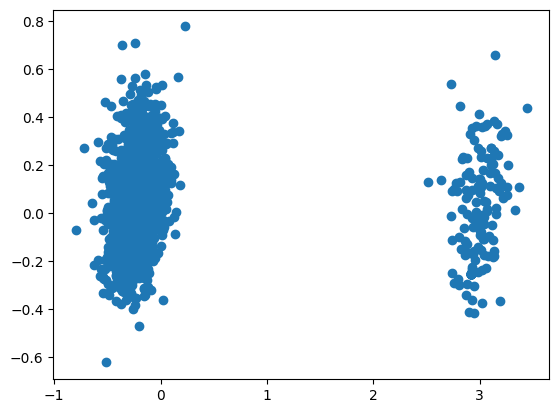

In [23]:
plt.scatter(pca_x, pca_y)

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

# Sample dataset of vectors (each row represents a vector)
dataset = embeds

# Target vector for which you want to find the nearest neighbors
target_vector = embeds[8]

# Number of nearest neighbors to find (k)
k = 2

# Calculate cosine similarity between the target vector and all vectors in the dataset
similarities = cosine_similarity([target_vector], dataset.T)

# Flatten the similarities array and get the indices of the top-k values
nearest_indices = np.argsort(-similarities, axis=None)[:k]

# Retrieve the nearest neighbors based on the indices
nearest_neighbors = dataset[nearest_indices]

print("Nearest Neighbors:")
print(nearest_neighbors)


Nearest Neighbors:

             8         7

0     0.000000  0.000000

1     0.051372 -0.124901

2    -0.236245 -0.084323

3    -0.076958  0.160204

4    -0.055974 -0.224113

...        ...       ...

2234  0.149629 -0.055279

2235 -0.007207 -0.013456

2236  0.050560  0.192368

2237 -0.055718  0.080992

2238  0.000000  0.000000



[2239 rows x 2 columns]


In [25]:
sentences[8]

'in an attempt to induce glucose sensitive dna replication in vitro islets obtained from eighteen  and twenty day old fetal pancreata were cultured in the presence of either triiodothyronine or human growth hormone'

In [28]:
nearest_indices

array([8, 7])

In [29]:
sentences[7]

'however both high glucose and high amino acid concentrations increased the islet insulin secretion into the culture medium at all ages studied'